## ***Natural Languagem Processing*** to predict if a headline from a news website contains sarcasm - Data Modeling.

In this file, there will the data modeling to get a model to predict the data and to be evaluated.

In [257]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

In [4]:
SAMPLE_FRACTION = 0.03
TEST_SIZE = 0.33

sns.set_style("darkgrid")

In [5]:
sarcasm_df = pd.read_csv('sarcasm.csv')

sarcasm_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
X, y = sarcasm_df['headline'], sarcasm_df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=42, 
                                                    stratify=y
                                                )

train_data = pd.concat([X_train, y_train], axis=1)

class_counts = sarcasm_df['is_sarcastic'].value_counts(normalize=True)
train_data['weights'] = train_data['is_sarcastic'].map(class_counts)

sampled_data = train_data.sample(frac=SAMPLE_FRACTION, random_state=42, weights='weights')

X_train_sampled, y_train_sampled = sampled_data['headline'], sampled_data['is_sarcastic']

scv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
vectorizer = CountVectorizer()

X_train_vectorized = vectorizer.fit_transform(X_train)
X_train_sampled_vectorized = vectorizer.transform(X_train_sampled)
X_test_vectorized = vectorizer.transform(X_test)

X_train_df = pd.DataFrame(
    X_train_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)

X_sampled_train_df = pd.DataFrame(
    X_train_sampled_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)
    
X_test_df = pd.DataFrame(
    X_test_vectorized.toarray(),
    columns=vectorizer.get_feature_names_out()
)

class_0_counts = X_train_df[y_train.reset_index(drop=True) == 0].sum()
class_1_counts = X_train_df[y_train.reset_index(drop=True) == 1].sum()

word_diff = class_0_counts - class_1_counts

word_weights = dict(zip(word_diff.index, word_diff.values))

X_train_weighted = X_train_df.multiply(
    X_train_df.columns.map(word_weights),
    axis=1
)

X_train_sampled_weighted = X_sampled_train_df.multiply(
    X_sampled_train_df.columns.map(word_weights),
    axis=1
)

X_test_weighted = X_test_df.multiply(
    X_test_df.columns.map(word_weights),
    axis=1
)

In [7]:
stantard = StandardScaler()

X_train_weighted = stantard.fit_transform(X_train_weighted)
X_train_sampled_weighted = stantard.transform(X_train_sampled_weighted)
X_test_weighted = stantard.transform(X_test_weighted)

In [18]:
NB_model = BernoulliNB()

NB_param_grid = {
    'alpha': [0.5, 0.75, 1.0, 2.0]
}

NB_grid = GridSearchCV(
    estimator=NB_model,
    param_grid=NB_param_grid,
    cv=scv,
    n_jobs=2,
    scoring='f1_weighted'
).fit(X_train_sampled_weighted, y_train_sampled)

In [19]:
NB_grid.best_params_

{'alpha': 0.5}

In [ ]:
NB_best = NB_grid.best_estimator_.fit(X_train_weighted, y_train)

In [21]:
print(classification_report(y_train, NB_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, NB_best.predict(X_test_weighted), digits=3))

              precision    recall  f1-score   support

           0      0.940     0.961     0.950     10040
           1      0.949     0.921     0.935      7855

    accuracy                          0.944     17895
   macro avg      0.944     0.941     0.943     17895
weighted avg      0.944     0.944     0.944     17895

              precision    recall  f1-score   support

           0      0.835     0.895     0.864      4945
           1      0.852     0.774     0.811      3869

    accuracy                          0.842      8814
   macro avg      0.844     0.834     0.838      8814
weighted avg      0.843     0.842     0.841      8814



In [264]:
pca = PCA(n_components=2000)

X_train_pca = pca.fit_transform(X_train_weighted)

X_test_pca, X_train_sampled_pca = pca.transform(X_test_weighted), pca.transform(X_train_sampled_weighted)

In [266]:
NB_model = BernoulliNB()

NB_param_grid = {
    'alpha': [0.5, 0.75, 1.0, 2.0]
}

NB_grid = GridSearchCV(
    estimator=NB_model,
    param_grid=NB_param_grid,
    cv=scv,
    n_jobs=2,
    scoring='f1_weighted'
).fit(X_train_sampled_pca, y_train_sampled)

In [267]:
NB_grid.best_params_

{'alpha': 0.5}

In [268]:
NB_best = NB_grid.best_estimator_.fit(X_train_pca, y_train)

In [269]:
print(classification_report(y_train, NB_best.predict(X_train_pca), digits=3))

print(classification_report(y_test, NB_best.predict(X_test_pca), digits=3))

              precision    recall  f1-score   support

           0      0.728     0.752     0.740     10040
           1      0.670     0.642     0.655      7855

    accuracy                          0.704     17895
   macro avg      0.699     0.697     0.698     17895
weighted avg      0.703     0.704     0.703     17895

              precision    recall  f1-score   support

           0      0.715     0.717     0.716      4945
           1      0.637     0.634     0.636      3869

    accuracy                          0.681      8814
   macro avg      0.676     0.676     0.676      8814
weighted avg      0.680     0.681     0.681      8814



In [ ]:
RF_model = RandomForestClassifier(n_jobs=2, verbose=2)

RF_param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'log_loss', 'entropy'],
    'class_weight': [None, 'balanced']
}

RF_grid = GridSearchCV(
                estimator=RF_model,
                param_grid=RF_param_grid,
                cv=scv,
                n_jobs=2,
                scoring='f1_weighted',
                verbose=2
            ).fit(X_train_sampled_weighted, y_train_sampled)

In [26]:
RF_grid.best_params_

{'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 200}

In [ ]:
RF_best = RF_grid.best_estimator_.fit(X_train_weighted, y_train)

In [28]:
print(classification_report(y_train, RF_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, RF_best.predict(X_test_weighted), digits=3))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    3.7s finished


              precision    recall  f1-score   support

           0      1.000     1.000     1.000     10040
           1      1.000     1.000     1.000      7855

    accuracy                          1.000     17895
   macro avg      1.000     1.000     1.000     17895
weighted avg      1.000     1.000     1.000     17895



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    1.5s


              precision    recall  f1-score   support

           0      0.845     0.804     0.824      4945
           1      0.764     0.811     0.787      3869

    accuracy                          0.807      8814
   macro avg      0.804     0.807     0.805      8814
weighted avg      0.809     0.807     0.808      8814



[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    1.9s finished


In [ ]:
RF_model = RandomForestClassifier(n_jobs=2, class_weight='balanced', n_estimators=200, verbose=2)

RF_param_grid = {
    'max_depth': [2000, 1000, 500],
    'min_samples_leaf': [5, 4, 3]
}

RF_grid = GridSearchCV(
                estimator=RF_model,
                param_grid=RF_param_grid,
                cv=scv,
                n_jobs=2,
                scoring='f1_weighted'
            ).fit(X_train_sampled_weighted, y_train_sampled)

In [31]:
RF_grid.best_params_

{'max_depth': 500, 'min_samples_leaf': 3}

In [ ]:
RF_best = RF_grid.best_estimator_.fit(X_train_weighted, y_train)

In [ ]:
print(classification_report(y_train, RF_best.predict(X_train_weighted), digits=3))

print(classification_report(y_test, RF_best.predict(X_test_weighted), digits=3))

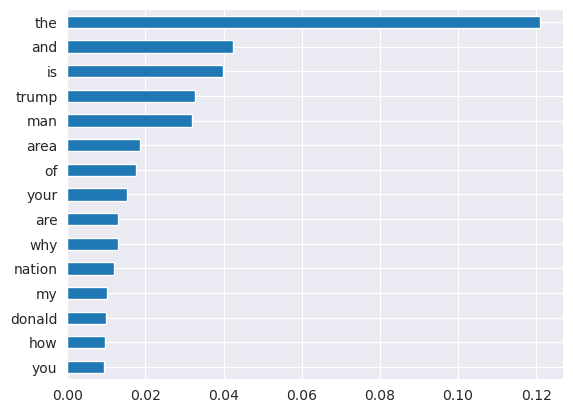

In [34]:
feat_importances = pd.Series(RF_best.feature_importances_, index=X_train_df.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh')

sns.despine()
plt.show()

## Neural Networks

In [239]:
X, y = sarcasm_df['headline'], sarcasm_df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=42, 
                                                    stratify=y
                                                )

In [240]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train, X_test = tokenizer.texts_to_sequences(X_train), tokenizer.texts_to_sequences(X_test)

sequences = X_train + X_test

vocab_size = len(tokenizer.word_index) + 1  

max_len = max(len(seq) for seq in sequences)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [241]:
train_data = pd.DataFrame({'X': list(X_train), 'is_sarcastic': y_train.tolist()})

sampled_data = train_data.groupby('is_sarcastic')[['X', 'is_sarcastic']].apply(
    lambda group: group.sample(frac=SAMPLE_FRACTION, random_state=42)
)

X_train_sampled, y_train_sampled = np.array(sampled_data['X'].tolist()), np.array(sampled_data['is_sarcastic'])

In [ ]:
def create_model(vocab_size, embedding_dim, input_length, learning_rate=0.001, dropout_rate=0.5, l2_rate=0.05, **kwargs):
    model = Sequential([
        Input(shape=(input_length,)),  
        Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        Flatten(),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate / 3),
        Dense(32, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate / 6),
        Dense(1, activation='sigmoid') 
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

sequence_length = X_train.shape[1]

keras_model = KerasClassifier(
    model=create_model,
    model__vocab_size=vocab_size,         
    model__embedding_dim=5,               
    model__input_length=sequence_length,  
    verbose=0
)

param_grid = {
    'model__l2_rate': [0.01, 0.05], 
    'model__dropout_rate': [0.1, 0.3],
    'fit__batch_size': [16, 24],     
    'fit__epochs': [10, 20]         
}

scv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=scv, scoring='f1_weighted')

grid_result = grid.fit(X_train_sampled, y_train_sampled)

In [250]:
grid_result.best_params_

{'fit__batch_size': 24,
 'fit__epochs': 20,
 'model__dropout_rate': 0.3,
 'model__l2_rate': 0.01}

In [251]:
NN_best = grid_result.best_estimator_.fit(X_train, y_train)

In [253]:
print(classification_report(y_test, NN_best.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.819     0.851     0.835      4945
           1      0.799     0.760     0.779      3869

    accuracy                          0.811      8814
   macro avg      0.809     0.805     0.807      8814
weighted avg      0.810     0.811     0.810      8814



In [ ]:
def fit_nn_model(embedding_dim, best_params):
    model = create_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,  
    input_length=sequence_length,
    learning_rate=0.001,  
    dropout_rate=best_params['model__dropout_rate'],  
    l2_rate=best_params['model__l2_rate']  
)
   
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(
            X_train, y_train,
            batch_size=best_params['fit__batch_size'],  
            epochs=best_params['fit__epochs'],  
            validation_split=0.2,  
            verbose=1
        )

    return accuracy_score(y_train, model.predict(X_train).round()), accuracy_score(y_test, model.predict(X_test).round())

In [256]:
results = {k: fit_nn_model(k, grid_result.best_params_) for k in range(5, 51, 5)}

Epoch 1/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6212 - loss: 0.7721 - val_accuracy: 0.8262 - val_loss: 0.4048
Epoch 2/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8887 - loss: 0.3113 - val_accuracy: 0.8399 - val_loss: 0.3938
Epoch 3/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9397 - loss: 0.2006 - val_accuracy: 0.8371 - val_loss: 0.4286
Epoch 4/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1337 - val_accuracy: 0.8223 - val_loss: 0.5043
Epoch 5/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9771 - loss: 0.0947 - val_accuracy: 0.8206 - val_loss: 0.5886
Epoch 6/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9853 - loss: 0.0666 - val_accuracy: 0.8153 - val_loss: 0.7401
Epoch 7/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9914 - loss: 0.0455 - val_accuracy: 0.8122 - val_loss: 0.8291
Epoch 8/20
597/597 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9919 - loss: 0.0420 - val_accuracy: 0.

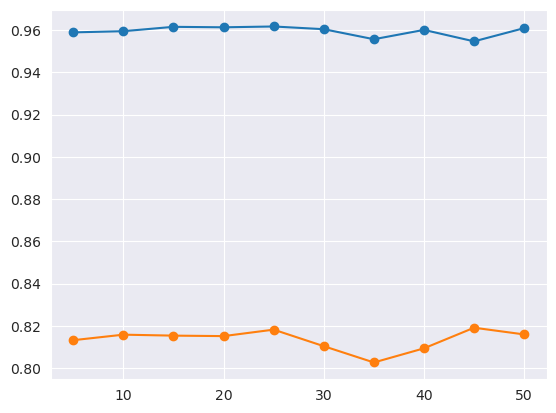

In [258]:
plt.plot(results.keys(), results.values(), marker='o')

plt.show()